# Landkreis: Weekly Cases + Deaths Model

## ToDo
* add uncertainty to mortality rate
* add reporting factor to death curve too
* multiple age groups
* use Refdata instead of Meldedatum
* try out scaling

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')
from datetime import datetime, timedelta
import pymc3 as pm
from os import walk
from scipy.stats import lognorm
from scipy import stats as sps

In [2]:
start_date = datetime(2020, 1, 1)
end_date = datetime.now().date() - timedelta(days=1)

In [3]:
(_, _, filenames) = next(walk('./RKI data'))
file_names = [name for name in filenames if name.startswith('RKI_COVID19')]
file_names.sort()
df_raw = pd.read_csv('./RKI data/' + file_names[-1], parse_dates=['Meldedatum', 'Refdatum'])
df_rki = df_raw.copy()
#df_rki['Meldedatum'] = pd.to_datetime(df_rki['Meldedatum'])
#df_rki['Refdatum'] = pd.to_datetime(df_rki['Refdatum'])
df_rki['week'] = df_rki['Meldedatum'].dt.week
df_rki = df_rki.query('Meldedatum > @start_date' 
              ' and Meldedatum <= @end_date')
df_rki['Meldeverzug'] = (df_rki['Meldedatum'] - df_rki['Refdatum']).dt.days

f"Found {df_rki['AnzahlFall'].sum():,} cases downloaded at {file_names[-1][12:26]}"

'Found 173,651 cases downloaded at 2020-05-16_10h'

In [4]:
df_rki[:3]

,Unnamed: 0,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,ObjectId,Meldedatum,...,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2,week,Meldeverzug
0,0,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,6628040,2020-03-14,...,"16.05.2020, 00:00 Uhr",0,-9,2020-03-16,0,1,1,Nicht übermittelt,11,-2
1,1,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,6628041,2020-03-19,...,"16.05.2020, 00:00 Uhr",0,-9,2020-03-13,0,1,1,Nicht übermittelt,12,6
2,2,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,6628042,2020-03-19,...,"16.05.2020, 00:00 Uhr",0,-9,2020-03-16,0,1,1,Nicht übermittelt,12,3


In [5]:
df_rki['Altersgruppe'].unique()

array(['A15-A34', 'A35-A59', 'A60-A79', 'A80+', 'A05-A14', 'A00-A04',
       'unbekannt'], dtype=object)

In [8]:
days_per_week = df_rki[['week', 'Meldedatum']].drop_duplicates()
weeks_ending = days_per_week.groupby('week')['Meldedatum'].max().reset_index()
weeks_ending.columns = ['week', 'last_dow']
weeks_ending = weeks_ending.set_index('week')['last_dow']
weeks_ending.name = 'Last Day of Week'

n_days = days_per_week.groupby('week').size()
complete = n_days[n_days == 7]
max_complete_week = complete.index.max()
first_death_week = df_rki.query('AnzahlTodesfall > 0')['week'].min()
first_death_week, max_complete_week

(10, 19)

In [ ]:
weekly_totals = df_rki.query('week >= @first_death_week')\
                     .groupby(['week', 'Altersgruppe'])[['AnzahlFall']].sum()

sns.lineplot(x='week',y='AnzahlFall', hue='Altersgruppe', data=weekly_totals.reset_index())
plt.title('Neue Fälle');

In [ ]:
from matplotlib import ticker

case_weighted = df_rki.groupby('Meldeverzug')['AnzahlFall'].sum()
case_weighted.loc[-5:30].plot()

## Refdatum vs Meldedatum

In [ ]:
by_begin = df_rki.groupby(['Meldedatum', 'IstErkrankungsbeginn'])['AnzahlFall'].sum().reset_index()
by_begin = by_begin.pivot(index='Meldedatum', columns='IstErkrankungsbeginn', values='AnzahlFall').fillna(0)
by_begin.plot()

## Epidemilogical paramters

*Incubation Period and Other Epidemiological Characteristics of 2019 Novel Coronavirus Infections with Right Truncation: A Statistical Analysis of Publicly Available Case Data* Linton, Kobayashi, et al. 17th of Feb

In [ ]:
incubation = np.random.lognormal(1.525, .625, size=100000)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].hist(incubation, bins=range(30))
axes[0].set_title('Incubation Period')
death = np.random.lognormal(2.865, .533, size=100000)
axes[1].hist(death, bins=range(60))
_= axes[1].set_title('Illness to Death')

In [ ]:
# generation time
# Quantifying SARS-CoV-2 transmission suggests epidemic control with digital contact tracing Ferretti, Fraser et al.

In [ ]:
gen_time = np.random.weibull(2.826, size=100000) *  5.665
plt.figure(figsize=(5,3))
_= plt.hist(gen_time, bins=range(30))

In [ ]:
def lognorm_frame(mu, sigma):
    incubation_time = lognorm(s=sigma, scale=np.exp(mu))
    cdf = pd.Series(incubation_time.cdf(range(90)))
    daily_p = cdf - cdf.shift(1).fillna(0)
    return daily_p

cum_inc_time = lognorm_frame(1.525, 0.625)[:22]
cum_tt_death = lognorm_frame(2.865, 0.533)

def to_weekly_dist(dist):
    week_starts = np.array(range(0,len(dist) + 1, 7))
    cum_dist = dist.cumsum() / dist.sum()
    weekly = (cum_dist[week_starts] - cum_dist[week_starts].shift(1).fillna(0))
    weekly.index = (weekly.index / 7).astype(int)
    return weekly

infection_to_death = pd.Series(np.convolve(cum_inc_time, cum_tt_death))
to_weekly_dist(infection_to_death).plot(figsize=(5,2))
plt.title('Infection to Death')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

In [7]:
inf_to_death = pd.Series(np.convolve(cum_inc_time, cum_tt_death))
for  i in range(3, 8):
    print(f'{inf_to_death.cumsum()[i * 7]:.0%} of deaths during first {i} weeks')

NameError: name 'cum_inc_time' is not defined

### 90% of deaths happen in the first 6 weeks after infection

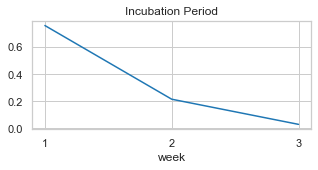

In [20]:
weekly_incubation = to_weekly_dist(cum_inc_time)
weekly_incubation[1:].plot(figsize=(5,2))
plt.title('Incubation Period')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xlabel('week');

In [21]:
# https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30243-7/fulltext
mortality = pd.DataFrame({
    'Altersgruppe': ['A15-A34', 'A35-A59', 'A60-A79', 'A80+'],
    'mortality' : [0.0005, 0.003, 0.03, 0.078]
})

In [22]:
kreise = df_rki.groupby('Landkreis')['AnzahlTodesfall'].sum().sort_values(ascending=False)
kreise[kreise.index.str.startswith('SK B')]
kreise['LK Pinneberg'], kreise['SK Berlin Friedrichshain-Kreuzberg']

(37, 5)

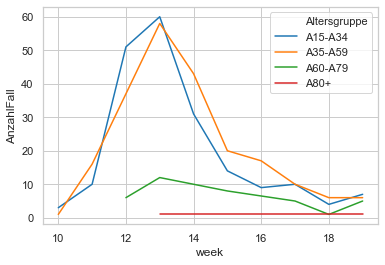

In [117]:
cases_by_age = df_rki.query("week <= @max_complete_week and Landkreis == 'SK Berlin Friedrichshain-Kreuzberg'")\
                     .groupby(['Altersgruppe', 'week'])['AnzahlFall'].sum()\
                     .reset_index()
to_drop = cases_by_age['Altersgruppe'].isin(['A00-A04', 'A05-A14', 'unbekannt'])
cases_by_age = cases_by_age[~to_drop]
sns.lineplot(x='week', y='AnzahlFall', hue='Altersgruppe', data=cases_by_age)

Dropped age groups: 


Altersgruppe
A00-A04    0
A05-A14    0
Name: AnzahlTodesfall, dtype: int64

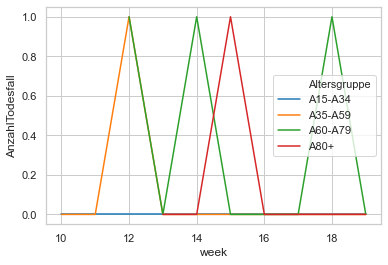

In [118]:
complete_weeks = df_rki.query("week >= @first_death_week and week <= @max_complete_week and Landkreis == 'SK Berlin Friedrichshain-Kreuzberg'")
deaths_by_age = complete_weeks.groupby(['week', 'Altersgruppe'])['AnzahlTodesfall'].sum().reset_index()
to_drop = deaths_by_age['Altersgruppe'].isin(['A00-A04', 'A05-A14', 'unbekannt'])
print('Dropped age groups: ')
display(deaths_by_age[to_drop].groupby('Altersgruppe')['AnzahlTodesfall'].sum())
deaths_by_age['cartesian_key'] = True

deaths_by_age = deaths_by_age[~to_drop]
_= sns.lineplot(x='week', y='AnzahlTodesfall', hue='Altersgruppe', data=deaths_by_age)

## Bayesian cases based on deaths

In [216]:
age_group = 'A60-A79'
min_death_week = deaths_by_age.query('Altersgruppe == @age_group and AnzahlTodesfall > 0')['week'].min()
# start death data with first week where there are still 0 deaths.
min_death_week = min_death_week - 1

# allow time for cases to lead to deaths at week min_death_week
start_offset = 2
start_week = min_death_week - start_offset
# deaths from last week might not be reported yet
death_end_week = max_complete_week - 5
n_death_weeks = death_end_week - min_death_week + 1
n_weeks = max_complete_week - start_week + 1
print(f'n_weeks: {n_weeks}, start_week: {start_week}')
f'death_start_week: {min_death_week}, death_end_week: {death_end_week}, n_death_weeks: {n_death_weeks}'

n_weeks: 11, start_week: 9


'death_start_week: 11, death_end_week: 14, n_death_weeks: 4'

In [217]:
# this lower triangular matirx vectorizes the multiplication with r,
# which is composed of a starting value r_zero and it's changes over
# the following time points
TRIL = []
for i in range(1, n_weeks):
    row = list(range(1, i+1))
    row.reverse()
    n_zeros = n_weeks - i - 1
    if n_zeros > 0:
        row = np.concatenate([row, np.zeros(n_zeros)])
    TRIL.append(row[:16])
TRIL = np.array(TRIL)
print(TRIL.shape)
TRIL[:3,:3]

(10, 10)


array([[1., 0., 0.],
       [2., 1., 0.],
       [3., 2., 1.]])

In [218]:
def create_delay_matrix(delay):
    def pad_delay_series(delay):
        if n_weeks > delay.shape[0]:
            padded_delay = np.concatenate([delay.values, 
                                           np.zeros(n_weeks - delay.shape[0])])
        else:
            padded_delay = delay.values[:n_weeks]
        padded_delay = pd.Series(padded_delay)
        return padded_delay
    padded_delay = pad_delay_series(delay)
    res = [padded_delay.shift(i).fillna(0).values for i in range(n_weeks)]
    return np.array(res).T

DD = create_delay_matrix(weekly_incubation)
# n_weeks, n_weeks
print(DD.shape)
DD[:3,:3]

(11, 11)


array([[0.        , 0.        , 0.        ],
       [0.75535453, 0.        , 0.        ],
       [0.21460865, 0.75535453, 0.        ]])

In [219]:
def fill_missing_weeks(weekly_values, min_week, max_week):
    all_weeks = pd.DataFrame({'week': range(min_week, max_week + 1)})
    weekly_values = all_weeks.merge(weekly_values, how='left', on='week') \
                             .set_index('week') \
                             .fillna(0)
    return weekly_values
    
deaths = deaths_by_age.query('Altersgruppe == @age_group')
deaths = fill_missing_weeks(deaths, min_death_week, death_end_week)
deaths = deaths['AnzahlTodesfall']
deaths

week
11    0.0
12    1.0
13    0.0
14    1.0
Name: AnzahlTodesfall, dtype: float64

In [220]:
cases = cases_by_age.query('Altersgruppe == @age_group')
cases = fill_missing_weeks(cases, start_week, max_complete_week)
cases = cases['AnzahlFall']
cases

week
9      0.0
10     0.0
11     0.0
12     6.0
13    12.0
14    10.0
15     8.0
16     0.0
17     5.0
18     1.0
19     5.0
Name: AnzahlFall, dtype: float64

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185

Let $\gamma$ be ther inverse of the generation time. We model the number of $deaths(t)$ for people who got infected at time $t$.
$$ 
\begin{eqnarray}
\text{new infections}(t) &:=& \text{new infections}(t-1) \cdot e^{\gamma (r(t) -1)} \\
\operatorname{log}(\text{new infections})(t) &=& \operatorname{log}(\text{new infections}(t-1)) + \gamma (r(t) -1) \\
\text{expected cases}(t) &:=& \text{DelayMatrix} \cdot \text{new infections}(t) \\
\text{new deaths}(t) &:=& \operatorname{Normal}(\text{expected cases}(t) \cdot \text{mortality}(t))
\end{eqnarray}
$$

For each Landkreis we draw a mean growth rate $r_L$ and each age group gets a growth rate $r_{L,a}$ drawn from a narrow distribution around $r_L$.

In [298]:
import theano

# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# in weeks
serial_interval = 6/7
group_mortality = mortality.set_index('Altersgruppe').loc[age_group].iloc[0]

# shape = weeks, groups
# groups = age_groups times Landkreise

with pm.Model() as model:
    r_zero = pm.Normal('r_zero', np.log(3), 0.4)
    # r_sigma = pm.Gamma('r_sigma', 10, 100)
    r_delta = pm.Normal('r_delta', 0, 0.4, shape=n_weeks-2)
    r = pm.Deterministic('r', pm.math.concatenate([r_zero.flatten(), r_delta]))
    # substract 1 from the first entry of r, 
    # which substracts 1 from all r as they are the sum of the entries
    
    # log_infection are modelled linearly with slope sum_0^t (r[t] - 1) 
    start_infections = pm.Normal('start_infections', mu=0, sigma=10)
    
    # TODO: make the growth a logit
    # use matrix TRIL to vectorize the stepwise linear growth of the log_infections
    log_infection_following = start_infections + pm.math.dot(TRIL, r / serial_interval)
    all_log_infections = pm.math.concatenate([start_infections.flatten(), 
                                              log_infection_following])
    log_infections = pm.Deterministic('log_infections', all_log_infections)
    
    # the death delay matrix DD spreads infections out into the future 
    # weighted by the time to death probability on a future day
    expected_cases = pm.Deterministic('expected_cases', pm.math.dot(DD, np.exp(log_infections)))
    
    case_reporting_rate_zero = pm.Lognormal('case_reporting_rate_zero', mu=np.log(0.2), sigma=.5)
    reporting_sigma = 3 / (5 + np.arange(1, n_weeks-1))
    case_reporting_rate_factors = pm.Lognormal('case_reporting_rate_factors', mu=0, sigma=.15, shape=n_weeks-2)
    log_case_rep_rate = np.log(pm.math.concatenate([case_reporting_rate_zero.flatten(),
                                                    case_reporting_rate_factors]))                              
    case_reporting_rates = pm.Deterministic('case_reporting_rates', 
                                            np.exp(pm.math.dot(np.tril(np.ones(n_weeks-1)), 
                                                               log_case_rep_rate)))
    
    # the week of the first infections we still don't have cases, because of the incubation period
    reported_cases = pm.Normal('reported_cases', 
                                expected_cases[1:] * case_reporting_rates, 
                                # the plus 50 allows for undetected cases in the beginning
                                np.sqrt(expected_cases[1:] * case_reporting_rates) * 5, 
                                shape=n_weeks,
                                observed=cases[1:])
    
    expected_deaths = pm.Deterministic('expected_deaths', expected_cases * group_mortality)
    obs_deaths = pm.Normal('obs_deaths', 
                            expected_deaths[start_offset:start_offset+n_death_weeks],
                            sigma=np.sqrt(expected_deaths[start_offset:start_offset+n_death_weeks]),
                            shape=n_weeks, 
                            observed=deaths)

print(model.test_point)
model.check_test_point()

{'r_zero': array(1.09861229), 'r_delta': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'start_infections': array(0.), 'case_reporting_rate_zero_log__': array(-1.60943791), 'case_reporting_rate_factors_log__': array([0., 0., 0., 0., 0., 0., 0., 0., 0.])}


r_zero                                -0.00
r_delta                               -0.02
start_infections                      -3.22
case_reporting_rate_zero_log__        -0.23
case_reporting_rate_factors_log__      8.80
reported_cases                      -506.73
obs_deaths                            -5.20
Name: Log-probability of test_point, dtype: float64

In [299]:
# log_inf = pm.sample_prior_predictive(samples=10000, model=model, vars=['log_infections'])['log_infections']
# plt.plot(np.median(log_inf, axis=0))

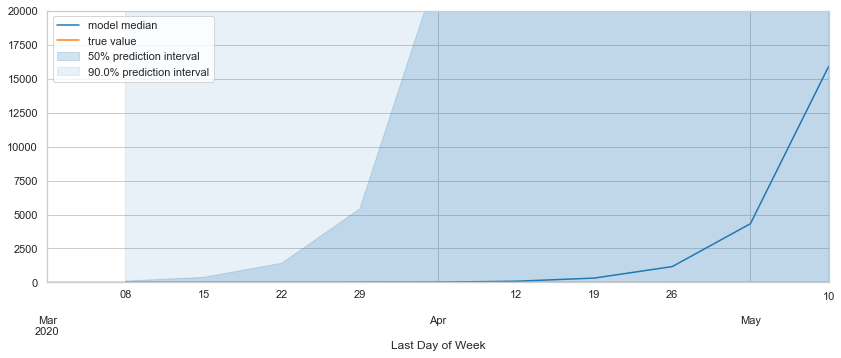

In [300]:
def week_numbers_to_dates(week_numbers):
    return weeks_ending.loc[week_numbers]


def plot_sample_with_quantiles(sample_values, offset, alpha=0.1, label=None, ax=None):
    if ax is None:
        plt.figure(figsize=(14, 5))
        ax = plt.gca()
    plot_with_q = pd.DataFrame(sample_values).apply(pd.Series.quantile, q=[alpha/2, 0.25, 0.5, 0.75, 1 - alpha/2]).T
    plot_with_q.index = week_numbers_to_dates(plot_with_q.index + offset)

    if label is None:
        label = 'model'
    plot_with_q[0.5].plot(ax=ax, label=label+' median')
    ax.fill_between(plot_with_q.index,
                     plot_with_q[0.25],
                     plot_with_q[0.75], 
                     alpha=0.2,
                     label=f'50% prediction interval',
                     color='C0')
    ax.fill_between(plot_with_q.index,
                     plot_with_q[alpha/2],
                     plot_with_q[1 - alpha/2], 
                     alpha=0.1,
                     label=f'{100 * (1 - alpha)}% prediction interval',
                     color='C0')

def sanity_check(true_values=None, obs_var_name='obs'):
    """
    :param m: (pm.Model)
    :param df: (pd.DataFrame)
    """
    # Sample from the prior and check of the model is well defined.
    y = pm.sample_prior_predictive(samples=10000, model=model, vars=[obs_var_name])[obs_var_name]
    plot_sample_with_quantiles(y, start_week + 1)
    true_values_to_plot = true_values.copy()
    true_values_to_plot.index = week_numbers_to_dates(true_values_to_plot.index)
    true_values_to_plot.plot(label='true value')
    plt.ylim([0, 2e4])
    plt.legend(loc='upper left')
    return y
    

# And run the sanity check
y = sanity_check(cases, 'reported_cases')

In [301]:
with model:
    #print(model.test_point)
    trace = pm.sample(init='adapt_diag')
    #trace = pm.sample(10000, tune=5000, step=pm.Metropolis())

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [case_reporting_rate_factors, case_reporting_rate_zero, start_infections, r_delta, r_zero]
Sampling 4 chains, 187 divergences: 100%|██████████| 4000/4000 [00:12<00:00, 318.59draws/s]
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.


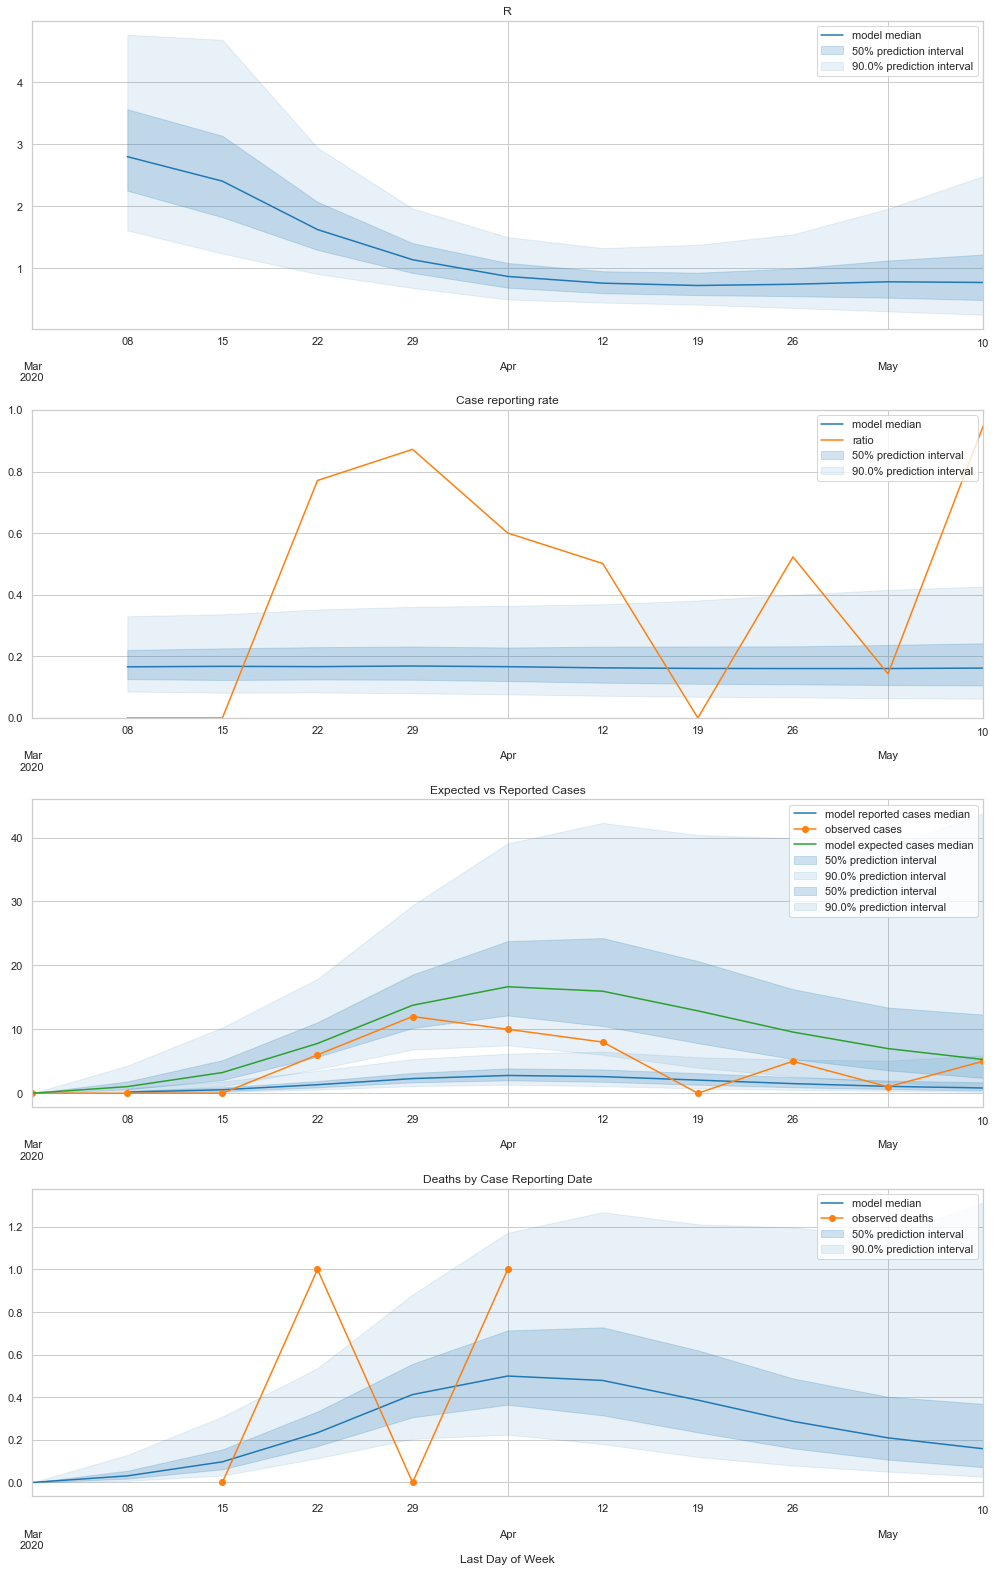

In [291]:
fig, axes = plt.subplots(4, 1, figsize=(14, 22), sharex=True)

r_eff = np.exp(np.cumsum(trace['r'], axis=1))
plot_sample_with_quantiles(r_eff, start_week + 1, ax=axes[0])
axes[0].set_title('R')
#axes[0].set_ylim([0, 5])
axes[0].legend()

plot_sample_with_quantiles(trace['case_reporting_rates'], start_week + 1, ax=axes[1])
case_comp = pd.DataFrame({'cases': cases, 'expected_cases': np.median(trace['expected_cases'], axis=0)})
case_comp['ratio'] = (case_comp['cases'] / (case_comp['expected_cases']))
case_comp.index = week_numbers_to_dates(case_comp.index)
case_comp['ratio'].plot(ax=axes[1])
axes[1].legend(loc='upper right')
axes[1].set_ylim([0, 1])
axes[1].set_title('Case reporting rate')

plot_sample_with_quantiles(trace['expected_cases'][:,1:] * trace['case_reporting_rates'], start_week + 1, label='model reported cases', ax=axes[2])
to_plot = cases.copy()
to_plot.index = week_numbers_to_dates(to_plot.index)
to_plot.plot(label='observed cases', ax=axes[2], marker='o')
plot_sample_with_quantiles(trace['expected_cases'], start_week, label='model expected cases', ax=axes[2])

axes[2].legend(loc='upper right')
#axes[2].set_ylim([0, 1e2])
axes[2].set_title('Expected vs Reported Cases')

plot_sample_with_quantiles(trace['expected_deaths'], start_week, ax=axes[3])
to_plot = deaths.loc[min_death_week:death_end_week].copy()
to_plot.index = week_numbers_to_dates(to_plot.index)
to_plot.plot(label='observed deaths', marker='o', ax=axes[3])
axes[3].legend()
axes[3].set_title('Deaths by Case Reporting Date');

for i in range(3):
    axes[i].xaxis.set_tick_params(which='both', labelbottom=True)
plt.tight_layout()

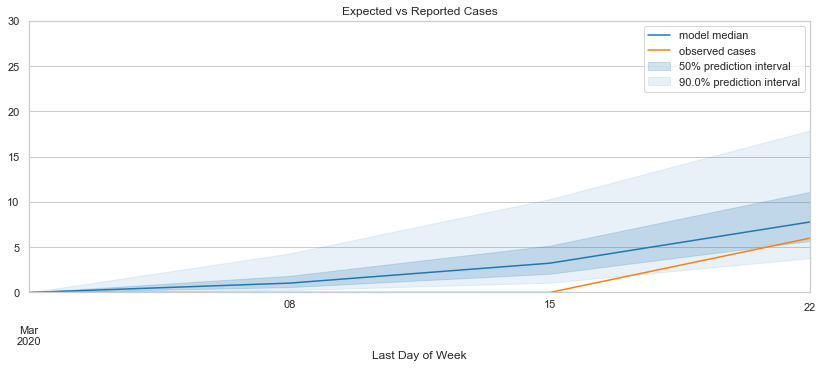

In [292]:
plot_sample_with_quantiles(trace['expected_cases'][:,:4], start_week)
to_plot = cases[:4].copy()
to_plot.index = week_numbers_to_dates(to_plot.index)
to_plot.plot(label='observed cases')
plt.legend(loc='upper right')
plt.ylim([0, 30])
plt.title('Expected vs Reported Cases');

In [293]:
infections = np.exp(np.median(trace['log_infections'], axis=0))
infections

array([ 1.36258649,  3.84238499,  9.08572122, 15.11506403, 17.24835513,
       15.28182961, 11.85429686,  8.55809365,  6.12355393,  4.69494607,
        3.72431404])

In [294]:
np.median(trace['expected_cases'], axis=0)

array([ 0.        ,  1.02923587,  3.22874872,  7.78122492, 13.75808486,
       16.65390026, 15.95887135, 12.88533801,  9.56377995,  6.97785121,
        5.27625876])

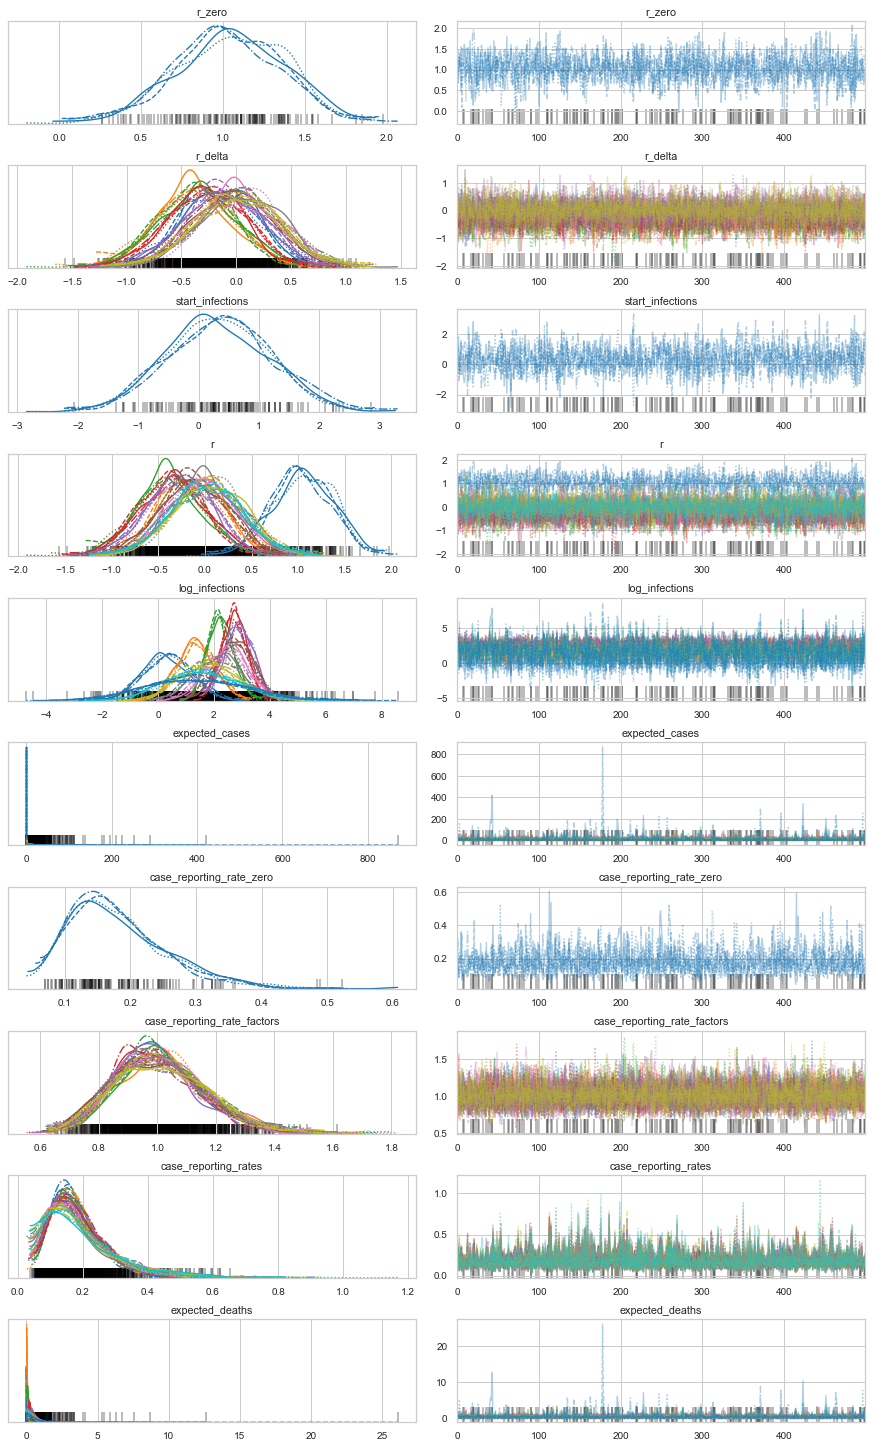

In [295]:
_ = pm.traceplot(trace)

In [ ]:
posterior = pm.sample_posterior_predictive(trace, model=model)

## Distribution Playground

4.206455297576834 8.163696735626681


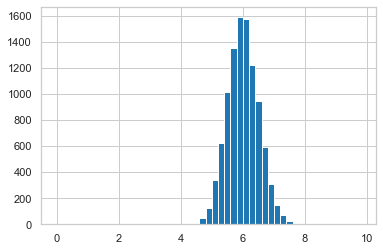

In [154]:
with pm.Model():
    a = pm.Gamma('a', mu=6, sigma=.5).random(size=10000)
    pd.Series(a).hist(bins=np.arange(0, 10, 0.2))
    print(a.min(), a.max())

3.3607680100521126e-11 28.621079261260288


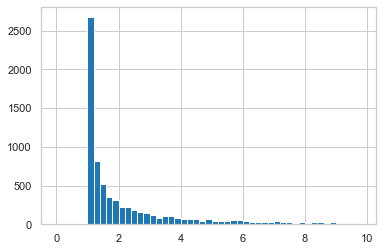

In [180]:
with pm.Model():
    a = pm.Gamma('a', mu=2, sigma=3).random(size=10000)
    np.exp(pd.Series(a)).hist(bins=np.arange(0, 10, 0.2))
    print(a.min(), a.max())

In [32]:
pm.Gamma('start_infections', mu=5, sigma=2)

4.394182439775738